In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
from multiprocessing import Pool, cpu_count
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [110]:
SNIPPET_DIR_PATH = '/home/unnc/Documents/_data/_snippet/'
ORIGIN_DIR_PATH = '/home/unnc/Documents/_data/_original_data/'


TRAIN_NAME = f'train'

TEST_17_NAME = f'test_17'
TEST_18_NAME = f'test_18'
TRAIN_3000_NAME = f'train_3000'

In [3]:

output_dir = ''
# SWAG_OUTPUT_DIR_PATH = '/home/unnc/Documents/_data/swag/' # Q C1 C2 C3 C4 C5

In [4]:
# original data
# train_original_data = pd.read_excel(f'{ORIGIN_DIR_PATH}train.xlsx', header=None)
test_original_data_17 = pd.read_excel(f'{ORIGIN_DIR_PATH}test_17-18.xlsx', sheet_name='2017', header=None)
test_original_data_18 = pd.read_excel(f'{ORIGIN_DIR_PATH}test_17-18.xlsx', sheet_name='2018', header=None)

In [5]:
test_original_data_17.columns = ['q','c1','c2','c3','c4','c5','q_type','year', 'a']
test_original_data_18.columns = ['q','c1','c2','c3','c4','c5','q_type','year', 'a']

In [675]:


OUTPUT_DIR_PATH = '/home/unnc/Desktop/snippet_type/_data/choice_all/' # QC1 QC2 QC3 QC4 QC5
snippet_type = 'lvl_5_table'

## Level 5_3

In [676]:
def _make_snippet_name_list():
    col_name_list = []
    for s in range(5):
        for t in range(5):
            col_name = f's{s}t{t}'
            col_name_list.append(col_name)
    return col_name_list

def join_snippet(file_name):
    snippet = {}
    for i in range(5):
        if file_name == 'test_17':
            path = f'{SNIPPET_DIR_PATH}/2017真题查询结果/分答案搜索/{snippet_type}/{file_name}_{i+1}.xlsx'
        if file_name == 'test_18':
            path = f'{SNIPPET_DIR_PATH}/2018真题查询结果/分答案搜索/{snippet_type}/{file_name}_{i+1}.xlsx'
        if file_name == 'train':
            path = f'{SNIPPET_DIR_PATH}/训练集查询结果/分答案搜索/{snippet_type}/{file_name}_{i+1}.xlsx'
        snippet[i] = pd.read_excel(path, header=None)
        snippet[i].columns = _make_snippet_name_list()
        index = np.arange(snippet[i].shape[0])*5 + i
        snippet[i]['snippet_index'] = index 
    return snippet

In [677]:
snippet_test_17_dict = join_snippet('test_17')
snippet_test_18_dict = join_snippet('test_18')

For a single question

$QC_1...C_5 \longrightarrow \sum_{c=1}^{5} QC_c$

question + 5 choice -> 5 * (question + 1 choice)

In [678]:
def expand_choices(df):
    """
    return:
    df with expanded choice
    """
    
    result = []
    question_index = df.columns.get_loc('q')
    first_choice_index = df.columns.get_loc('c1')
    answer_index = df.columns.get_loc('a')
    # iterate through all entries in df
    for i in tqdm(range(df.shape[0])):
        one_entry = df.iloc[i,:] 
        # for each entry, take its 5 choices in sequence into 5 [question, one_choice, label] outputs
        for choice_index in range(5):
            label = 1 if (choice_index + 1)  == one_entry[answer_index] else 0
            result.append({'q': one_entry[question_index], 
                       'c': one_entry[first_choice_index+choice_index],
                       'q_type': one_entry['q_type'],
                       'c_index': choice_index, 
                       'q_index': one_entry['q_index'],
                       'a': label})
    return pd.DataFrame(result)[['q','q_index','c','c_index','a','q_type']]

In [679]:
# def get_trunc_df(df_data):
#     qst_list = combine_qst(df_data, True, True, True)
#     df_trunc = df_data[['q','q_type','c1','c2','c3','c4','c5','a']].copy()
#     df_trunc['q'] = qst_list
#     return df_trunc
def add_question_index(df_data):
    question_len = df_data.shape[0]
    df_data['q_index'] = range(question_len)
    return df_data

# CORRUPTED!! TRAINING FILE LENGTH 

In [680]:
# snippet_train[0].shape

In [681]:
35507 - 2729

32778

In [682]:
#train_original_data.shape

In [683]:
test_17_expanded = expand_choices(add_question_index(test_original_data_17))
test_17_expanded['snippet_index'] = range(test_17_expanded.shape[0])

In [684]:
test_18_expanded = expand_choices(add_question_index(test_original_data_18))
test_18_expanded['snippet_index'] = range(test_18_expanded.shape[0])

In [685]:
print('17:', test_17_expanded.shape, '18:', test_18_expanded.shape)

17: (3000, 7) 18: (2995, 7)


In [686]:
snippet_test_17 = pd.concat([snippet_test_17_dict[i] for i in range(5)]).sort_values(by=['snippet_index'])
snippet_test_18 = pd.concat([snippet_test_18_dict[i] for i in range(5)]).sort_values(by=['snippet_index'])

In [687]:
test_17 = pd.merge(test_17_expanded, snippet_test_17)
test_18 = pd.merge(test_18_expanded, snippet_test_18)
print('17:', test_17.shape, '18:', test_18.shape)

17: (3000, 32) 18: (2995, 32)


# Data cleaning

### drop corruped data

In [688]:
# 1. handle corrupted row at 10040
# if train_with_snippet[train_with_snippet.iloc[:,8].isnull() != True].iloc[:,0].tolist() != []:
#     print(train_with_snippet[train_with_snippet.iloc[:,8].isnull() != True].iloc[:,0].tolist())
#     train_with_snippet.drop(train_with_snippet.index[10040], inplace=True)

In [689]:
# 2. handle wrong choice (longer than 400) at 21511
# if len(train_with_snippet.iloc[21509,2]) > 400:
#     print(train_with_snippet.iloc[21509,2])
#     train_with_snippet.drop(train_with_snippet.index[21509], inplace=True)
#     print('dropped')

### drop nan entries

In [690]:
# 0: question
# 1: question type
# 2-6: choices
# 7: answer
# 10: textbook snippet
# 11-14: title level 1-4
# train_data = train_with_snippet.iloc[:,[0,1,2,3,4,5,6,7,10,11,12,13,14]]

In [691]:
# train_with_snippet.head(1)

In [692]:
test_17

,q,q_index,c,c_index,a,q_type,snippet_index,s0t0,s0t1,s0t2,...,s3t0,s3t1,s3t2,s3t3,s3t4,s4t0,s4t1,s4t2,s4t3,s4t4
0,最有助于诊断室性心动过速的心电图特点是,0,T波和主波方向相反,0,0,A1,0,nan室上性心动过速的病因是通常无器质性心脏病。室上性心动过速的ECG特点是心率150-25...,内科学,心律失常,...,右束支阻滞的心电图表现QRS时限≥0.12s。V1-2导联呈rsR，R波粗钝；V5、V6导联...,内科学,心律失常,心脏传导阻滞,室内传导阻滞,no_name①窦性心律失常：病因和临床意义；病态窦房结综合征的心电图特点及处理原则；窦性心...,内科学,心律失常,考纲要求,no_name
1,最有助于诊断室性心动过速的心电图特点是,0,心室夺获,1,1,A1,1,nan室性心动过速的病因是各种器质性心脏病者冠心病最常见偶见于无器质性心脏病者。室性心动过速...,内科学,心律失常,...,超声心动图有助于了解心室壁的运动和左心室功能，诊断室壁瘤和乳头肌功能失调，检测心超声心动图有...,内科学,冠状动脉粥样硬化性心脏病,ST段抬高型急性心肌梗死,辅助检查,nan室上性心动过速的病因是通常无器质性心脏病。室上性心动过速的ECG特点是心率150-25...,内科学,心律失常,心动过速,三种心动过速的比较
2,最有助于诊断室性心动过速的心电图特点是,0,QRS波群宽大畸形,2,0,A1,2,nan室上性心动过速的病因是通常无器质性心脏病。室上性心动过速的ECG特点是心率150-25...,内科学,心律失常,...,no_name①窦性心律失常：病因和临床意义；病态窦房结综合征的心电图特点及处理原则；窦性心...,内科学,心律失常,考纲要求,no_name,nan室性心动过速的病因是各种器质性心脏病者冠心病最常见偶见于无器质性心脏病者。室性心动过速...,内科学,心律失常,心动过速,三种心动过速的比较
3,最有助于诊断室性心动过速的心电图特点是,0,QRS波群呈束支传导阻滞图形,3,0,A1,3,nan室上性心动过速的病因是通常无器质性心脏病。室上性心动过速的ECG特点是心率150-25...,内科学,心律失常,...,右束支阻滞的心电图表现QRS时限≥0.12s。V1-2导联呈rsR，R波粗钝；V5、V6导联...,内科学,心律失常,心脏传导阻滞,室内传导阻滞,加速性心室自主节律也称缓慢型室速。心电图表现为：①连续发生3～lO个起源于心室的加速性心室自...,内科学,心律失常,心动过速,特殊类型的室性心动过速
4,最有助于诊断室性心动过速的心电图特点是,0,PR间期延长,4,0,A1,4,no_name①窦性心律失常：病因和临床意义；病态窦房结综合征的心电图特点及处理原则；窦性心...,内科学,心律失常,...,nan室性心动过速的病因是各种器质性心脏病者冠心病最常见偶见于无器质性心脏病者。室性心动过速...,内科学,心律失常,心动过速,三种心动过速的比较,nan室上性心动过速的病因是通常无器质性心脏病。室上性心动过速的ECG特点是心率150-25...,内科学,心律失常,心动过速,三种心动过速的比较
5,属于支气管扩张手术治疗禁忌症的是,1,双下肺均存在局限性支气管扩张病变,0,0,A1,5,no_name①局限性支气管扩张，且经充分内科治疗仍顽固反复发作者，可考虑手术切除病变肺组织...,内科学,支气管扩张症,...,nan支气管扩张症是左下叶和左舌叶支气管,内科学,肺部感染性疾病(肺炎与肺脓肿),肺脓肿,病因和发病机制,nan支气管扩张症的发病年龄是儿童和青年。支气管扩张症的起病缓急是多慢性经过。支气管扩张症的...,内科学,肺部感染性疾病(肺炎与肺脓肿),肺脓肿,临床表现
6,属于支气管扩张手术治疗禁忌症的是,1,合并反复感染,1,0,A1,6,nan支气管扩张症的发病年龄是儿童和青年。支气管扩张症的起病缓急是多慢性经过。支气管扩张症的...,内科学,肺部感染性疾病(肺炎与肺脓肿),...,支气管扩张主要表现为反复咳嗽、咳大量脓痰和(或)反复咯血。肺部固定而持久的局限性湿支气管扩张...,内科学,慢性阻塞性肺疾病与支气管哮喘,慢性阻塞性肺疾病,鉴别诊断,干性支气管扩张部分患者以反复咯血为唯一症状，平时无咳嗽、咳脓痰等症状，临床上称为干干性支气管...,内科学,支气管扩张症,临床表现,症状
7,属于支气管扩张手术治疗禁忌症的是,1,窦性心动过缓，阿托品实验(+),2,0,A1,7,nan窦性心动过缓的临床表现或机制是强心苷可抑制窦房结，降低自律性而发生窦性心动过缓。窦性心...,药理学,治疗心衰的药物、抗动脉粥样硬化药与抗心绞痛药,...,nan不良反应是心动过缓，抑制心肌收缩力，抑制窦房结和房室结功能，收缩支气管，外周血管痉挛，...,内科学,高血压,原发性高血压,主要降压药物的种类及特点,nan人工流产综合反应的临床表现是是指术中或术毕出现心动过缓、心律不齐、面色苍白、头晕、胸闷...,妇产科学,计划生育与妇女保健,计划生育,人工流产
8,属于支气管扩张手术治疗禁忌症的是,1,合并大咯血,3,0,A1,8,no_name①局限性支气管扩张，且经充分内科治疗仍顽固反复发作者，可考虑手术切除病变肺组织...,内科学,支气管扩张症,...,大量咯血大咯血是肺结核患者的重要威胁。如咯血过程突然中断，出现呼吸急促、发绀、烦躁大量咯血大...,内科学,肺结核,治疗,咯血的治疗,no_name支气管扩张症：病因和发病机制，临床表现，诊断与鉴别诊断，并发症，治疗。支气管扩...,内科学,支气管扩张症,考纲要求,no_name
9,属于支气管扩张手术治疗禁忌症的是,1,合并肺心病,4,1,A1,9,nan支气管扩张症的发病年龄是儿童和青年。支气管扩张症的起病缓急是多慢性经过。支气管扩张症的...,内科学,肺部感染性疾病(肺炎与肺脓肿),...,no_name支气管扩张症：病因和发病机制，临床表现，诊断与鉴别诊断，并发症，治疗。支气管扩...,内科学,支气管扩张症,考纲要求,no_name,no_name肺心病的基本病理变化为各种原因所致的肺动脉高压一肺循环障碍一右室肥大、扩张一肺心病。,病理学,呼吸系统疾病,慢性肺源性心脏病,no_name


In [693]:
col_list_basic = ['snippet_index', 'q', 'q_type', 'c', 'a']
col_list_sippet_best = ['s0t0','s0t1','s0t2','s0t3','s0t4']

In [694]:
col_list = col_list_basic + col_list_sippet_best
test_17_data = test_17.loc[:,col_list]
test_18_data = test_18.loc[:,col_list]

In [695]:
test_17_data.head(5)

,snippet_index,q,q_type,c,a,s0t0,s0t1,s0t2,s0t3,s0t4
0,0,最有助于诊断室性心动过速的心电图特点是,A1,T波和主波方向相反,0,nan室上性心动过速的病因是通常无器质性心脏病。室上性心动过速的ECG特点是心率150-25...,内科学,心律失常,心动过速,三种心动过速的比较
1,1,最有助于诊断室性心动过速的心电图特点是,A1,心室夺获,1,nan室性心动过速的病因是各种器质性心脏病者冠心病最常见偶见于无器质性心脏病者。室性心动过速...,内科学,心律失常,心动过速,三种心动过速的比较
2,2,最有助于诊断室性心动过速的心电图特点是,A1,QRS波群宽大畸形,0,nan室上性心动过速的病因是通常无器质性心脏病。室上性心动过速的ECG特点是心率150-25...,内科学,心律失常,心动过速,三种心动过速的比较
3,3,最有助于诊断室性心动过速的心电图特点是,A1,QRS波群呈束支传导阻滞图形,0,nan室上性心动过速的病因是通常无器质性心脏病。室上性心动过速的ECG特点是心率150-25...,内科学,心律失常,心动过速,三种心动过速的比较
4,4,最有助于诊断室性心动过速的心电图特点是,A1,PR间期延长,0,no_name①窦性心律失常：病因和临床意义；病态窦房结综合征的心电图特点及处理原则；窦性心...,内科学,心律失常,考纲要求,no_name


In [696]:
# drop entries that has any nan and, 
# print num of nan in each col
def any_nan_values(df):
    return df.isnull().values.any()

def drop_nan(df):
    if any_nan_values(df):
        print("nan in each col:\n", df.isnull().sum(), sep='')
        
        return df.dropna()
    return df

In [697]:
# train_data = drop_nan(train_data)
# reset index after dropping rows
# train_data.reset_index(inplace=True)
#train_data = train_data.drop(columns='index')

In [698]:
# assert every cell is not nan
# assert not any_nan_values(train_data) 
assert not any_nan_values(test_17_data) and not any_nan_values(test_18_data)

### add column headers

In [699]:
#train_data.columns = ['q', 'q_type', 'c1', 'c2', 'c3', 'c4', 'c5', 'a', 's1', 's1t1', 's1t2', 's1t3', 's1t4']

#test_17_data.columns = ['q','c1','c2','c3','c4','c5', 'q_type', 'year', 'a', 's1','s1t1','s1t2','s1t3','s1t4']
#test_18_data.columns = ['q','c1','c2','c3','c4','c5', 'q_type', 'year', 'a', 's1','s1t1','s1t2','s1t3','s1t4']

In [700]:
test_17_data.head(5)

,snippet_index,q,q_type,c,a,s0t0,s0t1,s0t2,s0t3,s0t4
0,0,最有助于诊断室性心动过速的心电图特点是,A1,T波和主波方向相反,0,nan室上性心动过速的病因是通常无器质性心脏病。室上性心动过速的ECG特点是心率150-25...,内科学,心律失常,心动过速,三种心动过速的比较
1,1,最有助于诊断室性心动过速的心电图特点是,A1,心室夺获,1,nan室性心动过速的病因是各种器质性心脏病者冠心病最常见偶见于无器质性心脏病者。室性心动过速...,内科学,心律失常,心动过速,三种心动过速的比较
2,2,最有助于诊断室性心动过速的心电图特点是,A1,QRS波群宽大畸形,0,nan室上性心动过速的病因是通常无器质性心脏病。室上性心动过速的ECG特点是心率150-25...,内科学,心律失常,心动过速,三种心动过速的比较
3,3,最有助于诊断室性心动过速的心电图特点是,A1,QRS波群呈束支传导阻滞图形,0,nan室上性心动过速的病因是通常无器质性心脏病。室上性心动过速的ECG特点是心率150-25...,内科学,心律失常,心动过速,三种心动过速的比较
4,4,最有助于诊断室性心动过速的心电图特点是,A1,PR间期延长,0,no_name①窦性心律失常：病因和临床意义；病态窦房结综合征的心电图特点及处理原则；窦性心...,内科学,心律失常,考纲要求,no_name


In [701]:
# rearange df columns to match the ones in training data
# test_17_data = test_17_data[train_data.columns]
# test_18_data = test_18_data[train_data.columns]

In [702]:
# Draw question len && snippet len graph 
# def draw_q_s_len(df):
#     q_len = [len(str(i).replace(' ', '')) for i in df['q']]
#     s1_len = [len(str(i).replace(' ', '')) for i in df['s0t0']]

#     len_512 = round(sum([i > 512 for i in s1_len]) / len(s1_len), 2)
#     len_756 = round(sum([i > 756 for i in s1_len]) / len(s1_len), 2)
#     len_1024 = round(sum([i > 1024 for i in s1_len]) / len(s1_len), 2)

#     label = f'snippet:   >512: {len_512}       >756: {len_756}      >1024: {len_1024}'

#     a = sns.distplot(s1_len, kde=False, axlabel=label)
#     a = sns.distplot(q_len, kde=False)
#     a = a.get_figure()
#     a.savefig(f'/{TRUNC_OUTPUT_DIR_PATH}/{output_dir}/qs.png', dpi=120, bbox_inches='tight')
#     print('saved to:', TRUNC_OUTPUT_DIR_PATH)

In [703]:
# draw_q_s_len(test_17_data)

# Add textbook snippit - only the best match

In [704]:
def _combine_titles(df_titles):
    """
    df_titles: any cleaned df that contains title information 
    
    return: list
    """
    return [' '.join(titles) for titles in df_titles[['s0t1', 's0t2', 's0t3', 's0t4']].values]


def combine_qst(df_data, add_q=True, add_s=True, add_t=True):
    """
    return: list
    
    output sequence is [title + question + snippet]
    """
    result = []
    if add_t:
        t = _combine_titles(df_data)
    q = df_data['q'].values
    s1 = df_data['s0t0'].values
    
    for i in range(df_data.shape[0]):
        assert 'æ' not in t[i] and 'æ' not in q[i] and 'æ' not in s1[i], 'Input data contains æ sign'
        all_tqs = [t[i], q[i], s1[i]] # change output sequence here
        input_tqs = [] 
        for i, add in enumerate([add_t, add_q, add_s]): # should be the same sequence as all_tqs
            if add:
                input_tqs.append(all_tqs[i])
        input_row = '  æ  '.join(input_tqs)
        result.append(input_row)
    print(f'First output is \n{result[0]}')
    return result

In [705]:
def get_trunc_df(df_data):
    qst_list = combine_qst(df_data, True, True, True)
    df_trunc = df_data.copy()
    df_trunc['input'] = qst_list
    return df_trunc
# def add_question_index(df_data):
#     question_len = df_data.shape[0]
#     df_data['q_index'] = range(question_len)
#     return df_data

In [706]:
# train_trunc = get_trunc_df(train_data)
# train_trunc = add_question_index(train_trunc)

In [707]:
test_17_trunc = get_trunc_df(test_17_data)
# test_17_trunc = add_question_index(test_17_trunc)

First output is 
内科学 心律失常 心动过速 三种心动过速的比较  æ  最有助于诊断室性心动过速的心电图特点是  æ  nan室上性心动过速的病因是通常无器质性心脏病。室上性心动过速的ECG特点是心率150-250次／分，节律规则QRS波正常，伴束支或室内差异性阻滞时可有宽QRS波逆行P波。室上性心动过速的临床表现是可突然发生、突然终止持续时间长短不一心悸、紧张、乏力等。室上性心动过速的治疗是刺激迷走神经终止发作腺苷、维拉帕米洋地黄、B受体阻滞剂电复律、射频等治疗。


In [708]:
test_18_trunc = get_trunc_df(test_18_data)
# test_18_trunc = add_question_index(test_18_trunc)
assert test_18_trunc.shape[0] == 2995 and test_17_trunc.shape[0] == 3000

First output is 
外科学 尿路结石 上尿路结石 诊断  æ  要了解肾结核患者分侧肾功能、病变程度与范围。首选的方法是  æ  CT平扫CT有助于鉴别不透光的结石、肿瘤、凝血块等。增强CT可显示肾积水的程度和肾实CT平扫CT有助于鉴别不透光的结石、肿瘤、凝血块等。增强CT可显示肾积水的程度和肾实质的厚度，从而有助于了解肾功能的改变情况。


In [709]:
test_17_trunc

,snippet_index,q,q_type,c,a,s0t0,s0t1,s0t2,s0t3,s0t4,input
0,0,最有助于诊断室性心动过速的心电图特点是,A1,T波和主波方向相反,0,nan室上性心动过速的病因是通常无器质性心脏病。室上性心动过速的ECG特点是心率150-25...,内科学,心律失常,心动过速,三种心动过速的比较,内科学 心律失常 心动过速 三种心动过速的比较 æ 最有助于诊断室性心动过速的心电图特点...
1,1,最有助于诊断室性心动过速的心电图特点是,A1,心室夺获,1,nan室性心动过速的病因是各种器质性心脏病者冠心病最常见偶见于无器质性心脏病者。室性心动过速...,内科学,心律失常,心动过速,三种心动过速的比较,内科学 心律失常 心动过速 三种心动过速的比较 æ 最有助于诊断室性心动过速的心电图特点...
2,2,最有助于诊断室性心动过速的心电图特点是,A1,QRS波群宽大畸形,0,nan室上性心动过速的病因是通常无器质性心脏病。室上性心动过速的ECG特点是心率150-25...,内科学,心律失常,心动过速,三种心动过速的比较,内科学 心律失常 心动过速 三种心动过速的比较 æ 最有助于诊断室性心动过速的心电图特点...
3,3,最有助于诊断室性心动过速的心电图特点是,A1,QRS波群呈束支传导阻滞图形,0,nan室上性心动过速的病因是通常无器质性心脏病。室上性心动过速的ECG特点是心率150-25...,内科学,心律失常,心动过速,三种心动过速的比较,内科学 心律失常 心动过速 三种心动过速的比较 æ 最有助于诊断室性心动过速的心电图特点...
4,4,最有助于诊断室性心动过速的心电图特点是,A1,PR间期延长,0,no_name①窦性心律失常：病因和临床意义；病态窦房结综合征的心电图特点及处理原则；窦性心...,内科学,心律失常,考纲要求,no_name,内科学 心律失常 考纲要求 no_name æ 最有助于诊断室性心动过速的心电图特点是 ...
5,5,属于支气管扩张手术治疗禁忌症的是,A1,双下肺均存在局限性支气管扩张病变,0,no_name①局限性支气管扩张，且经充分内科治疗仍顽固反复发作者，可考虑手术切除病变肺组织...,内科学,支气管扩张症,治疗,外科治疗,内科学 支气管扩张症 治疗 外科治疗 æ 属于支气管扩张手术治疗禁忌症的是 æ no...
6,6,属于支气管扩张手术治疗禁忌症的是,A1,合并反复感染,0,nan支气管扩张症的发病年龄是儿童和青年。支气管扩张症的起病缓急是多慢性经过。支气管扩张症的...,内科学,肺部感染性疾病(肺炎与肺脓肿),肺脓肿,临床表现,内科学 肺部感染性疾病(肺炎与肺脓肿) 肺脓肿 临床表现 æ 属于支气管扩张手术治疗禁忌...
7,7,属于支气管扩张手术治疗禁忌症的是,A1,窦性心动过缓，阿托品实验(+),0,nan窦性心动过缓的临床表现或机制是强心苷可抑制窦房结，降低自律性而发生窦性心动过缓。窦性心...,药理学,治疗心衰的药物、抗动脉粥样硬化药与抗心绞痛药,治疗充血性心力衰竭的药物,强心苷(地高辛),药理学 治疗心衰的药物、抗动脉粥样硬化药与抗心绞痛药 治疗充血性心力衰竭的药物 强心苷(地高...
8,8,属于支气管扩张手术治疗禁忌症的是,A1,合并大咯血,0,no_name①局限性支气管扩张，且经充分内科治疗仍顽固反复发作者，可考虑手术切除病变肺组织...,内科学,支气管扩张症,治疗,外科治疗,内科学 支气管扩张症 治疗 外科治疗 æ 属于支气管扩张手术治疗禁忌症的是 æ no...
9,9,属于支气管扩张手术治疗禁忌症的是,A1,合并肺心病,1,nan支气管扩张症的发病年龄是儿童和青年。支气管扩张症的起病缓急是多慢性经过。支气管扩张症的...,内科学,肺部感染性疾病(肺炎与肺脓肿),肺脓肿,临床表现,内科学 肺部感染性疾病(肺炎与肺脓肿) 肺脓肿 临床表现 æ 属于支气管扩张手术治疗禁忌...


In [710]:
def draw_input_len(df):
    input_len = [len(i.replace(' ', '')) for i in df['input']]
    len_512 = round(sum([i > 512 for i in input_len]) / len(input_len), 2)
    len_756 = round(sum([i > 756 for i in input_len]) / len(input_len), 2)
    len_1024 = round(sum([i > 1024 for i in input_len]) / len(input_len), 2)

    label = f'test_17: >512: {len_512}       >756: {len_756}      >1024: {len_1024}'
    a = sns.distplot(input_len, kde=False, axlabel=label)
    a = a.get_figure()
    a.savefig(f'/{OUTPUT_DIR_PATH}/{snippet_type}/test_17_len.png', dpi=120, bbox_inches='tight')

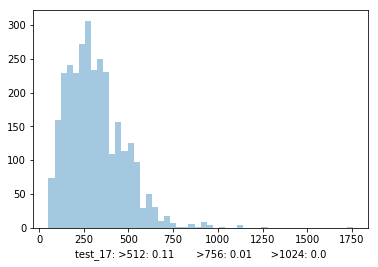

In [711]:
draw_input_len(test_17_trunc)

In [712]:
# def shuffle_df(df, frac=1, random_state=42):
#     return df.sample(frac=frac, random_state=random_state)

In [713]:
# train_trunc_shuffled = shuffle_df(train_trunc)

In [714]:
# train_trunc_shuffled.head(1)

In [715]:
# train_trunc_df = expand_choices(train_trunc_shuffled)

### Save files to help calculating accuracy

In [716]:
# def save_debug_file(df, file_name):
#     df.to_excel(f'{TRUNC_OUTPUT_DIR_PATH}/{output_dir}/{file_name}_debug.xlsx', index=None)
#     print(f'{file_name} saved!')

In [717]:
# save_debug_file(test_17_trunc_df, TEST_17_NAME)
# save_debug_file(test_18_trunc_df, TEST_18_NAME)
# save_debug_file(train_trunc_df.head(15000), TRAIN_3000_NAME)

### Preparing for bert

In [718]:
def prepare_for_bert(df):
    return pd.DataFrame({
        'id':range(df.shape[0]),
        'label':df['a'],
        'alpha':['a']*df.shape[0],
        'text_a': df['input'].replace(r'\n', ' ', regex=True),
        'text_b': df['c'].replace(r'\n', ' ', regex=True)
    })

In [719]:
test_18_trunc.head(1)

,snippet_index,q,q_type,c,a,s0t0,s0t1,s0t2,s0t3,s0t4,input
0,0,要了解肾结核患者分侧肾功能、病变程度与范围。首选的方法是,A1,CT平扫,0,CT平扫CT有助于鉴别不透光的结石、肿瘤、凝血块等。增强CT可显示肾积水的程度和肾实CT平扫...,外科学,尿路结石,上尿路结石,诊断,外科学 尿路结石 上尿路结石 诊断 æ 要了解肾结核患者分侧肾功能、病变程度与范围。首选...


In [720]:
# train_trunc_bert = prepare_for_bert(train_trunc_df)

test_17_trunc_bert = prepare_for_bert(test_17_trunc)
test_18_trunc_bert = prepare_for_bert(test_18_trunc)
# train_3000_trunc_bert = prepare_for_bert(train_trunc_df.head(15000))

In [721]:
# assert diff choices have diff input (snippet) for a same question
assert test_17_trunc_bert.head(5)['text_a'][1] != test_17_trunc_bert.head(5)['text_a'][3]

In [722]:
def save_input_file(df_bert, file_name):
    df_bert.to_csv(f'{OUTPUT_DIR_PATH}/{snippet_type}/{file_name}.tsv', 
                sep='\t', index=False, header=False)
    print(f'{file_name} saved!')

In [723]:
# save_input_file(train_trunc_bert, TRAIN_NAME)

In [724]:
save_input_file(test_17_trunc_bert, TEST_17_NAME)
save_input_file(test_18_trunc_bert, TEST_18_NAME)
# save_input_file(train_3000_trunc_bert, TRAIN_3000_NAME)

test_17 saved!
test_18 saved!


In [725]:
f'{OUTPUT_DIR_PATH}/{snippet_type}/{TEST_17_NAME}.tsv'

'/home/unnc/Desktop/snippet_type/_data/choice_all//lvl_5_table/test_17.tsv'